# Fine-Tuning Models
> An introductory example to fine-tuning models

In this walkthrough, we'll explore the standard steps of fine-tuning a model using huggingface, and we'll apply this towards the intuitive task of text classification.

We'll leverage the [`tweet_eval` dataset](https://huggingface.co/datasets/tweet_eval) to try to classify emotions of tweets into relevant categories.

# Initial Setup

### Install required packages
Note that this is mostly required if you're on Google Colab.

In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install --upgrade accelerate

### Import packages of interest

In [2]:
import numpy as np
import pandas as pd

from datasets import load_dataset, load_metric, Dataset
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from huggingface_hub import notebook_login

## Log into HuggingFace CLI
Why are we doing this? Below, we'll use our own user accounts to grab datasets and upload models. If we don't do this, we'll have to pass in the auth token over. This isn't bad, but let's streamline our efforts!

In [25]:
!git config --global credential.helper store

In [26]:
notebook_login()

# Load data from HuggingFace Hub, Datasets, or from disk

In this example, we'll pull from the Huggingface Datasets repository. However, if you have your own dataset, you could use that instead here.

In [5]:
#Load tweet_eval dataset, emotion configuration
demo_ds = load_dataset('tweet_eval', 'emotion')

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# View general structure of data
demo_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [7]:
# Look at an example
demo_ds['train'][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

In [8]:
# Look at labels
demo_ds['train'].features['label']

ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)

We can construct dictionaries that map these named labels to their numerical labels, which we'll use when defining the model a little later.

In [9]:
# Create id2label, label2id, and standard info from datasets
num_classes = demo_ds['train'].features['label'].num_classes
id2label = {ind:val for ind, val in enumerate(demo_ds['train'].features['label'].names)}
label2id = {val:key for key, val in id2label.items()}

print(num_classes)
print(id2label)
label2id

4
{0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}


{'anger': 0, 'joy': 1, 'optimism': 2, 'sadness': 3}

# Pre-process inputs
We've already learned about tokenizers - but let's see again what this looks like as we approach training. A richer treatment of tokenizers can be found in the Huggingface [instructions on tokenizers](https://huggingface.co/course/chapter2/4?fw=pt). 

Here, we'll need to apply our tokenizer to the full dataset.

In [10]:
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
tokenizer.name_or_path

'distilbert-base-cased'

In [11]:
#define tokenizing function
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation = True)

In [12]:
#do the tokenizing using map function
tokenized_ds = demo_ds.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

In [13]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
})

After the tokenization process, the dataset is transformed as follows:

The 'text' column is replaced with two new columns: 'input_ids' and 'attention_mask'.
The 'input_ids' column contains the tokenized input sequences represented as token IDs.
The 'attention_mask' column contains attention masks, which indicate which tokens should be attended to and which should be ignored during model training, making sure to ignore non-meaningful tokens (like truncated or padding tokens).

## An aside on dynamically padded batch size
HF has the capacity to dynamically pad your batches such that each input is only as long as any given input in the batch. This helps with memory.You can learn more [here](https://huggingface.co/course/chapter3/2?fw=pt). For now, we'll simply instantiate a data collator and use it during training to demonstrate how we can do this.

In [19]:
#Instantiate data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model Training Preparation

## Define model and task architecture

Let's define the model that we want to use. We'll take the [distilbert-base-cased](https://huggingface.co/distilbert-base-cased) model from huggingface, and define it with one of the `Auto` classes. Then, we give it some information about our data.

In [20]:
# Choose the model type and instantiate it for the task
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=num_classes,
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

## Define Metrics

### From Huggingface Datasets
Let's consider what metrics might be useful for training this model. Some metrics are available to us through [HF Datasets Metrics repo](https://huggingface.co/metrics).

Given that we are classifying tweets as evoking a particular emotion, the "accuracy" metric - which determines what portion of the total sample was predicted accurately - is a good choice here.

In [21]:
#load a metric
metric = load_metric("accuracy")

#define the metric behavior
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-21-e5db288d97c2>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


### Custom definitions
We can also define our own. The function inputs are a tuple of logits and labels, and the function must return a dictionary of key-value pairs. The keys should be the name of the metric and the values should be the values of that metric. We'll see an example below.

In [22]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    #get predictions by using index of max logit
    predictions = np.argmax(logits, axis=-1)
    
    #calculate classification report
    perfs = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    perf_dict = dict(zip(['precision', 'recall', 'fscore'], perfs[:3]))
    
    #return dictionary
    return perf_dict

## Settings for Model Training
Now, let's set some parameters that will govern the training loop of the model training. This includes practical considerations such as:
* Where the model should be saved
* Whether the model should be pushed to hub
* How often to assess the performance of the model on the validation set

This is also where we could change settings for neural network training, including:
* Number of epochs to train
* Learning rate
* Optimizer parameters

We do this through [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) and the [Trainer class.](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) Let's take a look!

In [30]:
#set new training arguments
training_args = TrainingArguments(output_dir = "bert-emotion", #where the model should be saved
                                  logging_strategy = "epoch",
                                  evaluation_strategy="epoch", #how often to evaluate performance
                                  save_strategy='epoch',
                                  load_best_model_at_end = True,
                                  metric_for_best_model='fscore',
                                  greater_is_better=True,
                                  per_device_train_batch_size = 4,
                                  per_device_eval_batch_size = 4,
                                  num_train_epochs=3,
                                  push_to_hub=True, #whether or not to push to hub
                                  hub_strategy='checkpoint',
                                  report_to='all')

#set data and functionality for trainer
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=tokenized_ds['train'],
                  eval_dataset=tokenized_ds['validation'],
                  compute_metrics=compute_metrics)

/content/bert-emotion is already a clone of https://huggingface.co/apetulante/bert-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


# Train model
Now, let's actually train the model!

Below, we'll define a `model_init` function, which allows us to start training from the HF BERT training checkpoint (in other words, we start training from the HF weights we've downloaded).

This training is fairly quick (for a large model!), but will still take a few minutes to run. Hopefully, we will watch the metrics improve at the end of each epoch.

In [28]:
#define a model init function which will help us just start training from scratch
def model_init():
  return(AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=num_classes,
                                                           id2label=id2label,
                                                           label2id=label2id))

By assigning the model_init function to trainer.model_init, you can override the default model initialization behavior of the Trainer class, so instead of using the default model initialization provided during the Trainer instantiation, the Trainer will use the model_init function instead.

In most cases, you would directly provide the model instance to the Trainer constructor and avoid modifying these attributes, so in practice, this would mostly be for experimentation.

In [31]:
#example of how we can update trainer attributes (note that generally you wouldn't do this unless you're just experimenting around)
trainer.model = None
trainer.model_init = model_init

#actually train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,Fscore
1,0.877000,0.804503,0.744857,0.649470,0.676509
2,0.546200,1.005743,0.714789,0.656618,0.677364
3,0.269100,1.273655,0.697954,0.711039,0.702646


TrainOutput(global_step=2445, training_loss=0.5640955700708556, metrics={'train_runtime': 308.9712, 'train_samples_per_second': 31.624, 'train_steps_per_second': 7.913, 'total_flos': 94971645618192.0, 'train_loss': 0.5640955700708556, 'epoch': 3.0})

In [32]:
#it's recommended to push the final version to HF after training completes.
#Note that the code below takes FOREVER depending on the size of your model so you might consider NOT running
#this line until the end of class
trainer.push_to_hub(commit_message='end of training 3 epochs')

Upload file runs/May29_20-56-54_0eb21313a3aa/events.out.tfevents.1685393829.0eb21313a3aa.23532.2: 100%|#######…

To https://huggingface.co/apetulante/bert-emotion
   a462ce5..543d3d5  main -> main

   a462ce5..543d3d5  main -> main

To https://huggingface.co/apetulante/bert-emotion
   543d3d5..60341dd  main -> main

   543d3d5..60341dd  main -> main



'https://huggingface.co/apetulante/bert-emotion/commit/543d3d50d37c60cd82e81c1fbf80929bbea1e9d8'

# Using trained model with `Trainer`


## Evaluate
We can assess the performance of the model over a large number of inputs (e.g., the test set). Here, we initially look at the performance of the training set to make sure the model _can_ learn from the data we've provided.

In [33]:
eval_ds = trainer.evaluate(tokenized_ds['train'])
eval_ds

{'eval_loss': 0.14509542286396027,
 'eval_precision': 0.9597957937792059,
 'eval_recall': 0.9598577203703367,
 'eval_fscore': 0.9597735995217131,
 'eval_runtime': 6.6447,
 'eval_samples_per_second': 490.167,
 'eval_steps_per_second': 122.655,
 'epoch': 3.0}

This gives us a lot of information. Here's what each of these components is telling us:

* `epoch`: the epoch number at which the evaluation is performed.

* `eval_fscore`: the F1 score achieved during the evaluation. F1 score is a measure of the model's accuracy that balances precision and recall.

* `eval_loss`: the evaluation loss. The evaluation loss is a measure of how well the model performs on the evaluation dataset, with lower values indicating better performance.

* `eval_precision`: the precision achieved during the evaluation. Precision measures the proportion of correctly predicted positive instances out of all predicted positive instances.

* `eval_recall`: the recall achieved during the evaluation. Recall measures the proportion of correctly predicted positive instances out of all actual positive instances.

* `eval_runtime`: the total runtime of the evaluation process in seconds.

* `eval_samples_per_second`: the number of samples processed per second.

* `eval_steps_per_second`: the number of batches processed per second.


## Predict
We can also use the model to predict and have the actual logits returned to us. This is helpful if we want to better inspect the performance of the model to consider consistent reasons for misclassifications and ideas on how to improve the performance of our model.

In [34]:
#use trainer to predict
preds = trainer.predict(tokenized_ds['train'])
preds

PredictionOutput(predictions=array([[-1.8868837, -1.8574343,  6.055155 , -1.419183 ],
       [ 5.531574 , -2.2868607, -2.86304  , -1.0091813],
       [-1.5225724,  5.9447274, -2.7839324, -1.9488443],
       ...,
       [ 5.8136845, -2.1721785, -2.4972744, -1.7975125],
       [ 5.2868667, -2.345863 , -1.9640478, -1.5634456],
       [ 5.5580554, -2.1184847, -2.1770754, -1.969078 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.14509542286396027, 'test_precision': 0.9597957937792059, 'test_recall': 0.9598577203703367, 'test_fscore': 0.9597735995217131, 'test_runtime': 9.3018, 'test_samples_per_second': 350.148, 'test_steps_per_second': 87.618})

We can see that our predictions are in the format of an array of lists. Each of these lists in our array show, for each object in the array, the "probability" that the tweet belongs to each of our classes ({0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}).

The highest probability becomes the classification.

Next, we may want to inspect some specific examples that the model got wrong, and build a confusion matrix of these predictions, which allows us to see what classes get confused - where the model has trouble distinguishing.

In [35]:
#sklearn has great built-in confusion matrix functionality
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

,pred_ids,label_ids,text
5,0,0,@user but your pussy was weak from what I hear...
6,3,3,Making that yearly transition from excited and...
7,1,1,Tiller and breezy should do a collab album. Ra...
8,0,0,@user broadband is shocking regretting signing...
9,0,0,@user Look at those teef! #growl


,pred_ids,label_ids,text,pred_labels,true_labels,is_misclassified
11,0,3,#NewYork: Several #Baloch &amp; Indian activis...,anger,sadness,True
91,0,1,Said it before and I'll say it now: America is...,anger,joy,True
98,0,3,@user &gt; huff louder,anger,sadness,True
131,3,0,"significantly, with a #bitter smile, 'let me",sadness,anger,True
166,0,3,"@user wow , your right they do need help,so wh...",anger,sadness,True
...,...,...,...,...,...,...
3204,0,3,@user it's Bowers. I went and drove it for a w...,anger,sadness,True
3222,0,3,"2day's most used term is, #terrorism, with man...",anger,sadness,True
3227,0,3,#Malaysian police arrest 4 people for suspecte...,anger,sadness,True
3232,3,2,"Once you've accepted your flaws, no one can us...",sadness,optimism,True


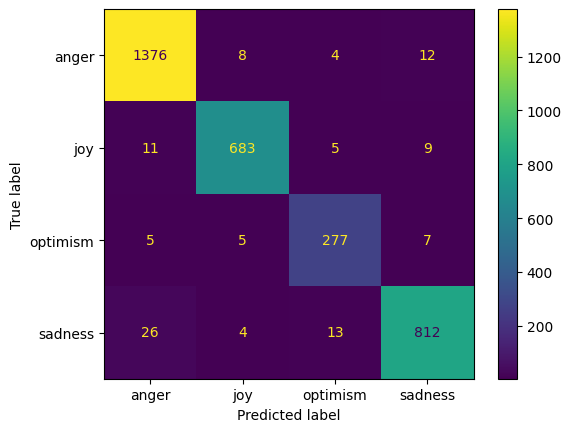

In [42]:
# Create a dataframe for inspection
preds_df = pd.DataFrame({'pred_ids':np.argmax(preds.predictions, axis=-1),
                         'label_ids':preds.label_ids,
                         'text':demo_ds['train']['text']})
display(preds_df[5:10])

# Populate pred_labels
preds_df['pred_labels'] = preds_df['pred_ids'].replace(id2label)
preds_df['true_labels'] = preds_df['label_ids'].replace(id2label)

# Define misclassified
preds_df['is_misclassified'] = preds_df['pred_ids'] != preds_df['label_ids']
display(preds_df.query('is_misclassified == True'))

# Get confusion matrix
ConfusionMatrixDisplay.from_predictions(preds_df['true_labels'], preds_df['pred_labels'])

In [38]:
#an example of inspecting the results to see examples of incorrect labels
preds_df.query("true_labels=='joy' and pred_labels=='sadness'")['text'].tolist()

['@user maybe he had constipation issues..? Not that I KNOW dates relieve such an affliction! No way jose!',
 "my alarm clock was ringing this morning n my flatmate knocked on my door and asked if i set anything on fire or if i'm burning alive :) :):)",
 'Contactless affliction kart are the needs must regarding the psychological moment!: xbeUJGB',
 '@user and have social anxiety. There is many awkward things wrong with me. 😄',
 "@user I've left it for my dad to deal with 😂 My work is done as soon as it's felt the wrath of my slipper 😷",
 'myself that despite the absolute delight my children and I would feel having a kitten in our home, the misery my husband would feel is more.',
 '@user @user grim should find broken Matt hardy because he can delete everything lol',
 "Can't even believe just seeing you set my anxiety off 🖕",
 "me taking a picture by myself: *awkward smile*\\nme on picture day: *awkward smile*\\nconclusion: stop smiling ;'(\\n#pictureday2016 #smile #ornot"]

# Using your fine-tuned model
Now, you can use the model that you've saved locally or that you've pushed to hub within a pipeline. Let's see how this works.

In [41]:
#create pipeline from your classifier
#this should be locally saved in the files to the left
emotion_classifier = pipeline('text-classification', model='bert-emotion/checkpoint-2445');

#optionally, load from HF
#emotion_classifier = pipeline('text-classification', model='{{your-HF-username}}/bert-emotion', use_auth_token=True)

#get output
emo = emotion_classifier(['The cat is prettier than any cat I have ever seen.',
                          'Opposums are criminally underrated.'])


In [40]:
#inspect results
emo

[{'label': 'joy', 'score': 0.9980871677398682},
 {'label': 'anger', 'score': 0.9984768033027649}]

# Optional Homework
Now that you've learned the essentials of training, here are some questions/exercises you can do to reflect on what we've learned, augment your knowledge, and avoid some known pitfalls.

## Tokenizers

In [43]:
#@title Tokenizers: Verifying your understanding

#@markdown We've inspected what tokenized data looks like.
#@markdown But we haven't gone deep into what padding tokens and truncated tokens may look like.
#@markdown Investigate the tokenized dataset and compare it to the version
#@markdown that wasn't tokenized. Does the tokenizers treatment of the
#@markdown data make sense to you?

In [ ]:
#@title Expanding our knowledge of Datasets `map` method
#@markdown What if we wanted to remove all html from our
#@markdown data prior to tokenization? We can do this with the map
#@markdown of Datasets. Use the following resource from the
#@markdown [HuggingFace Course](https://huggingface.co/course/chapter5/3?fw=pt#the-map-methods-superpowers) to understand how one might
#@markdown go about doing this. Implement this here.

## Training Arguments and the Trainer Class

In [ ]:
#@title Model metrics
#@markdown Let's say that we wanted to see the precision and recall
#@markdown for each of the individual classes rather than the `macro` averaging
#@markdown as we saw in our current `compute_metrics` function we've written.

#@markdown Using the same sklearn functions (or not, but sklearn may make it easier),
#@markdown return the precision and recall for each individual class label in addition
#@markdown to the macro scores. Recall that what is returned from the `compute_metrics`
#@markdown function must be a dictionary.

In [ ]:
#@title TrainingArguments parameters
#@markdown We've logged, saved, and evaluated at each epoch. However,
#@markdown if we have an extremely large dataset, seeing one or more of these
#@markdown at the end of each epoch (e.g., if it takes 3 hours to make it through
#@markdown a single epoch) may conflict with our desire to monitor our model training.

#@markdown 1. Using the TrainingArguments API, change your model to log, evaluate, and save
#@markdown every 200 steps rather than every epoch.
#@markdown 2. How does this change your checkpointing directories?
#@markdown 3. How does this influence the intervals of evaluation?

## Your own data
Of course, you can try all this out with your own data, or on a different task! The huggingface [Datasets](https://huggingface.co/docs/datasets/index) library has many useful functionalities for building your own dataset and hosting it on huggingface.

Or, [browse](https://huggingface.co/datasets) for an existing dataset that interests you, and think about what type of tasks could suit that dataset.